# Aurora Forecast Pro - Analyse geomagnetischer Stürme

## 1. Setup und Bibliotheken

In [ ]:
# Importe & Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Bibliotheken
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


# Grafik-Design
sns.set_style("ticks")
plt.rcParams.update({
    'font.size': 11,
    'figure.figsize': (10, 6),
    'axes.grid': True,
    'grid.alpha': 0.3
})

print("Bibliotheken geladen und Einstellungen gesetzt.")

# Warnungen unterdrücken
import warnings
warnings.filterwarnings('ignore')

Bibliotheken geladen und Einstellungen gesetzt.


## 2. Datenimport

In [ ]:
# Datenimport
print("Lade Daten...")
import os

file_path = 'omni_data.txt' 

if os.path.exists(file_path):
    col_names = ['Year', 'DOY', 'Hour', 'By', 'Bz', 'Density', 'Speed', 'Kp_10']
    
    # Einlesen
    df = pd.read_csv(file_path, delim_whitespace=True, names=col_names)
    
    # Zeitstempel erstellen
    df['Datetime'] = pd.to_datetime(df['Year'] * 1000 + df['DOY'], format='%Y%j') + pd.to_timedelta(df['Hour'], unit='h')
    df = df.set_index('Datetime')
    
    # Cleaning
    
    df = df.replace([999.9, 9999.99, 999.99, 9999, 99.9], np.nan)
    
    # --- HIER WIRD DIE SPALTE 'Kp' ERSTELLT ---
    df['Kp'] = df['Kp_10'] / 10.0 
    # ---------------------------------------------------
    
    print(f"Daten geladen. Spalten im Dataframe: {df.columns.tolist()}")
else:
    print("Datei nicht gefunden!")

Lade Daten...
Daten geladen. Spalten im Dataframe: ['Year', 'DOY', 'Hour', 'By', 'Bz', 'Density', 'Speed', 'Kp_10', 'Kp']


## 3. Datenbereinigung (Preprocessing)

In [3]:
# Kopie erstellen, um Warnungen zu vermeiden
df_clean = df.copy()

# 1. Zeitstempel generieren
# Kombination aus Jahr, Tag des Jahres (DOY) und Stunde zu einem Datetime-Objekt
df_clean['Datetime'] = pd.to_datetime(df_clean['Year'] * 1000 + df_clean['DOY'], format='%Y%j') + pd.to_timedelta(df_clean['Hour'], unit='h')
df_clean = df_clean.set_index('Datetime')

# 2. Fehlwerte behandeln
# OMNIWeb nutzt 999.9 etc. als Platzhalter für fehlende Messungen
error_values = [999.9, 9999.99, 999.99, 9999, 99.9]
df_clean = df_clean.replace(error_values, np.nan)

# 3. Zielvariable skalieren
# Kp-Index ist als Faktor 10 gespeichert (33 -> 3.3)
df_clean['Kp'] = df_clean['Kp_10'] / 10.0

# 4. Finaler Datensatz
# Nur relevante Spalten behalten und Zeilen mit NaNs entfernen
cols_to_keep = ['Bz', 'Speed', 'Density', 'Kp']
df_clean = df_clean[cols_to_keep].dropna()

print(f"Daten bereinigt. Verbleibende Datenpunkte: {len(df_clean)}")
print(df_clean.describe())  

Daten bereinigt. Verbleibende Datenpunkte: 182259
                  Bz          Speed        Density             Kp
count  182259.000000  182259.000000  182259.000000  182259.000000
mean       -0.019455     421.111654       6.070953       1.640859
std         2.682689      97.450710       4.869279       1.277383
min       -46.500000     233.000000       0.100000       0.000000
25%        -1.300000     348.000000       3.000000       0.700000
50%         0.000000     398.000000       4.700000       1.300000
75%         1.200000     475.000000       7.500000       2.300000
max        37.500000    1154.000000     137.200000       9.000000


## 4. Explorative Datenanalyse: Korrelationen

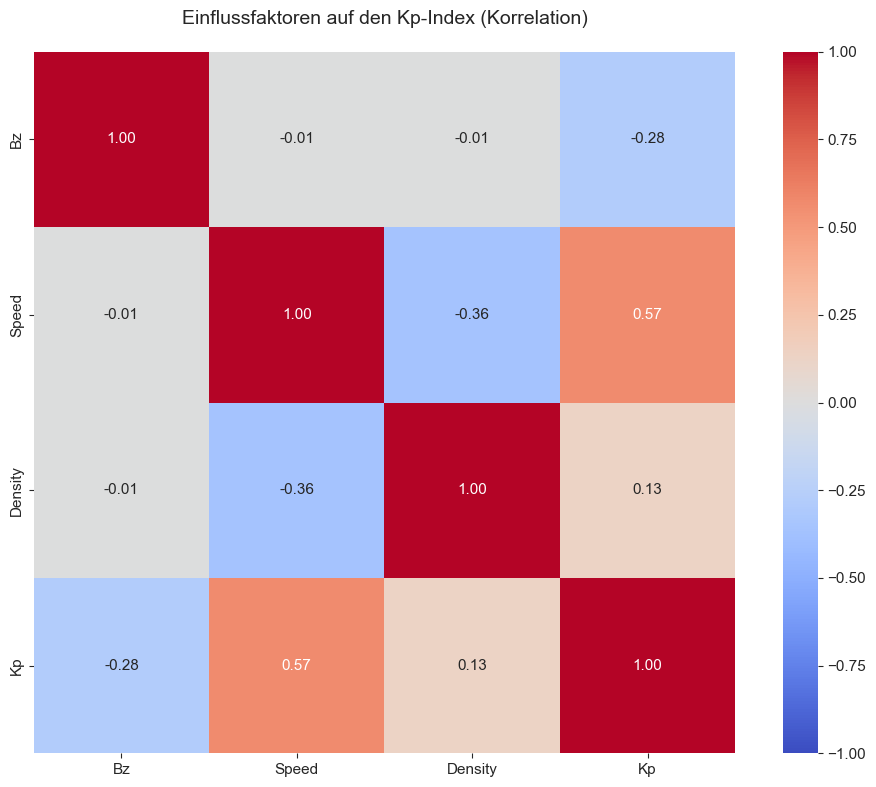

In [4]:
# Berechnung der Korrelationsmatrix nach Pearson
corr_matrix = df_clean.corr()

# Visualisierung als Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, square=True)
plt.title('Einflussfaktoren auf den Kp-Index (Korrelation)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('grafik_1_heatmap.png', dpi=300) # (hohe Auflösung)
plt.show()

## 5. Visualisierung der Hypothesen

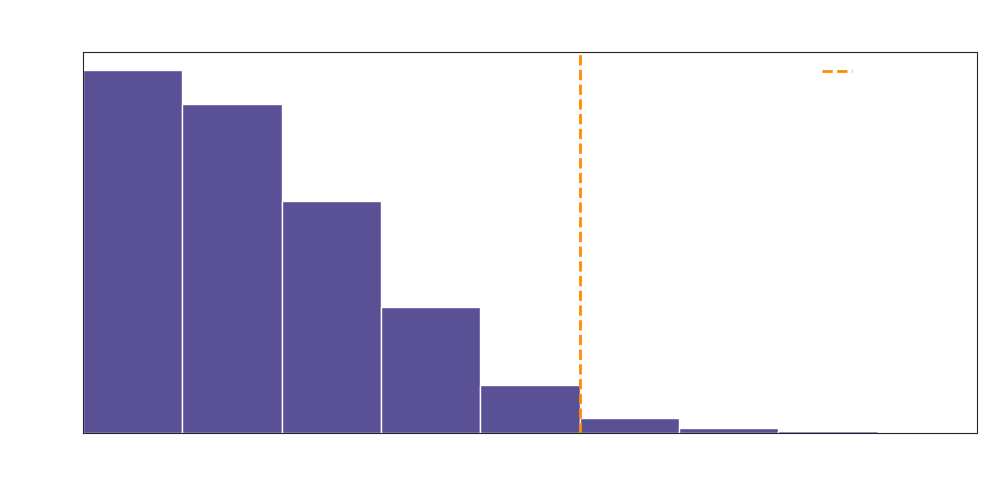

In [5]:
#Histogramm

# Style für transparente Plots anpassen
sns.set_style("ticks")
plt.rcParams.update({'font.size': 11, 'axes.facecolor': 'none', 'figure.facecolor': 'none'})

# Plot erstellen
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Kp'], bins=np.arange(0, 11, 1), color='#483D8B', edgecolor='white', alpha=0.9)
plt.axvline(5, color='#FF8C00', linestyle='--', linewidth=2, label='Sturm (Kp ≥ 5)')
plt.xticks(np.arange(0.5, 10.5, 1), labels=np.arange(0, 10, 1))
plt.xlim(0, 9)

# Titel und Achsenbeschriftungen weiss machen für dunklen Hintergrund
plt.title('Häufigkeitsverteilung (Kp-Index)', fontsize=14, pad=20, color='white')
plt.xlabel('Kp Index', fontsize=12, color='white')
plt.ylabel('Häufigkeit', fontsize=12, color='white')
plt.tick_params(colors='white') # Achsen-Zahlen weiss

# Legende anpassen
legend = plt.legend()
plt.setp(legend.get_texts(), color='white')
legend.get_frame().set_facecolor('none') # Legenden-Box transparent
legend.get_frame().set_edgecolor('white')

plt.tight_layout()

plt.savefig('grafik_3_histogramm_transparent.png', dpi=300, transparent=True)
plt.show()

Transparente Grafik gespeichert!


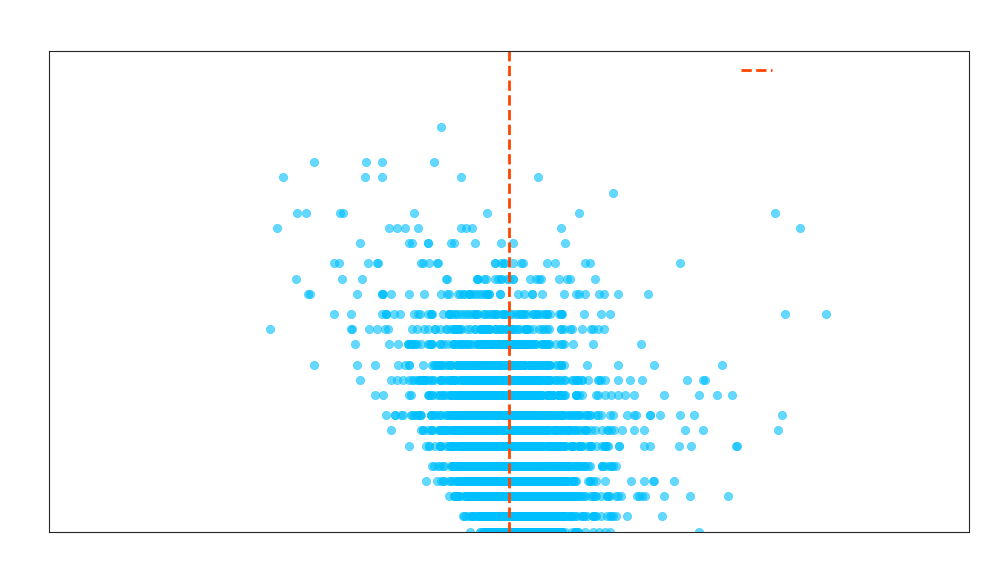

In [ ]:
#Scatterplot

# Style anpassen
sns.set_style("ticks")
plt.rcParams.update({'font.size': 11, 'axes.facecolor': 'none', 'figure.facecolor': 'none'})

df_sample = df_clean.sample(n=5000, random_state=42)
plt.figure(figsize=(10, 6))

sns.scatterplot(x='Bz', y='Kp', data=df_sample, alpha=0.6, color='#00BFFF', edgecolor=None)
plt.axvline(0, color='#FF4500', linestyle='--', linewidth=2, label='Kritische Grenze (Bz = 0)')

plt.ylim(0, 9.5)
plt.yticks(np.arange(0, 10, 1))
plt.xlim(-30, 30)

# Texte auf Weiss umstellen
plt.title('Zusammenhang: Magnetfeld (Bz) & Sturmstärke (Kp)', fontsize=14, pad=20, color='white')
plt.xlabel('Interplanetares Magnetfeld Bz (nT)', fontsize=12, color='white')
plt.ylabel('Geomagnetischer Index (Kp)', fontsize=12, color='white')
plt.tick_params(colors='white')

# Legende anpassen
legend = plt.legend(loc='upper right')
plt.setp(legend.get_texts(), color='white')
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('white')

plt.grid(True, alpha=0.2, color='white') # Gitterlinien leicht weiss
plt.tight_layout()

plt.savefig('grafik_2_scatterplot_transparent.png', dpi=300, transparent=True)
print("Transparente Grafik gespeichert!")
plt.show()

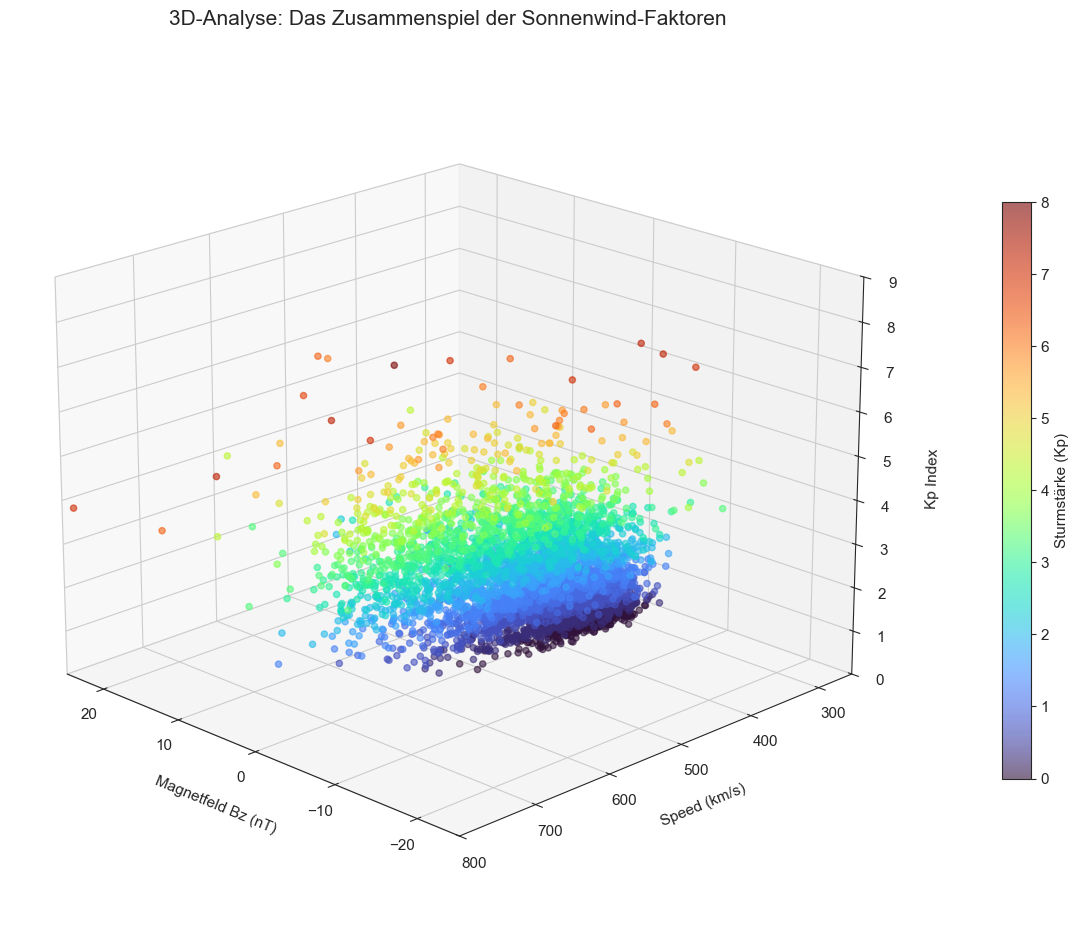

In [7]:
#3D Plot

# Style
sns.set_style("white") 
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Wir nehmen ein Sample, damit der Plot nicht zu voll wird (Performance & Optik)
df_3d = df_clean.sample(n=5000, random_state=42)

# Der Plot:
# X-Achse: Bz
# Y-Achse: Speed
# Z-Achse: Kp
# Farbe: Kp 
img = ax.scatter(df_3d['Bz'], df_3d['Speed'], df_3d['Kp'], 
                 c=df_3d['Kp'], cmap='turbo', alpha=0.6, s=20)

# Labels und Design
ax.set_xlabel('Magnetfeld Bz (nT)', fontsize=11, labelpad=10)
ax.set_ylabel('Speed (km/s)', fontsize=11, labelpad=10)
ax.set_zlabel('Kp Index', fontsize=11, labelpad=10)
ax.set_title('3D-Analyse: Das Zusammenspiel der Sonnenwind-Faktoren', fontsize=15, pad=20)

# Grenzen setzen für saubere Optik
ax.set_xlim(-25, 25)
ax.set_ylim(250, 800)
ax.set_zlim(0, 9)

# Farblegende hinzufügen
cbar = fig.colorbar(img, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Sturmstärke (Kp)')

# Blickwinkel einstellen (Elevation, Azimuth)
ax.view_init(elev=20, azim=135)

plt.tight_layout()
plt.savefig('grafik_4_3d_plot.png', dpi=300)
plt.show()

## 6. Feature Engineering (Vorbereitung für ML)

In [ ]:
# --- KONFIGURATION ---
FORECAST_HORIZON = 3   # Vorhersage für in 3 Stunden
STORM_THRESHOLD = 5    # Kp >= 5 gilt als Sturm

print(f"Konfiguration: Vorhersage-Horizont: {FORECAST_HORIZON}h | Sturm-Schwelle: Kp ≥ {STORM_THRESHOLD}")

# Relevante Prädiktoren auswählen
features = ['Bz', 'By', 'Speed', 'Density']
df_model = df[features + ['Kp']].dropna().copy()

# Zielvariable erstellen (Binäre Klassifikation: 1=Sturm, 0=Kein Sturm)
df_model['Is_Storm'] = (df_model['Kp'] >= STORM_THRESHOLD).astype(int)

# --- LAGGING ---
# Wir verschieben das Ziel (Target) in die Vergangenheit der Zeile.
# X(t) soll y(t + horizon) vorhersagen.
df_model['Target_Future'] = df_model['Is_Storm'].shift(-FORECAST_HORIZON)

df_model = df_model.dropna()

print(f"Datensatz bereit für Modellierung. Anzahl Samples: {len(df_model)}")
df_model.head()

Konfiguration: Vorhersage-Horizont: 3h | Sturm-Schwelle: Kp ≥ 5
Datensatz bereit für Modellierung. Anzahl Samples: 182256


,Bz,By,Speed,Density,Kp,Is_Storm,Target_Future
Datetime,,,,,,,
2004-01-01 00:00:00,3.1,6.1,525.0,6.8,3.3,0,0.0
2004-01-01 01:00:00,-3.4,5.7,529.0,5.9,3.3,0,0.0
2004-01-01 02:00:00,-1.5,5.6,540.0,5.3,3.3,0,0.0
2004-01-01 03:00:00,-2.3,6.6,558.0,5.3,3.7,0,0.0
2004-01-01 04:00:00,-1.2,6.1,543.0,5.2,3.7,0,0.0


## 7. Training (Random Forest Classifier)

In [ ]:
# Features (X) und Ziel (y) trennen
X = df_model[features]
y = df_model['Target_Future']

# Split in Training und Test

train_size = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training: {len(X_train)} Stunden | Test: {len(X_test)} Stunden")

# Modell initialisieren (Random Forest statt Logistic Regression)
# n_estimators=100: Anzahl der Bäume
# max_depth=10: Begrenzung der Tiefe gegen Overfitting
# class_weight='balanced': Wichtig, da Stürme selten sind!
model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)

# Trainieren
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

# Evaluation ausgeben
acc = accuracy_score(y_test, y_pred)
print(f"Modell Genauigkeit (Accuracy): {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Modelltraining mit Random Forest abgeschlossen.")

Training: 145804 Stunden | Test: 36452 Stunden
Modell Genauigkeit (Accuracy): 92.56%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     35697
         1.0       0.18      0.73      0.29       755

    accuracy                           0.93     36452
   macro avg       0.59      0.83      0.62     36452
weighted avg       0.98      0.93      0.95     36452

Modelltraining mit Random Forest abgeschlossen.


## 8. Evaluation & Ergebnisse

--- MODEL PERFORMANCE ---
              precision    recall  f1-score   support

  Kein Sturm       0.99      0.93      0.96     35697
       Sturm       0.18      0.73      0.29       755

    accuracy                           0.93     36452
   macro avg       0.59      0.83      0.62     36452
weighted avg       0.98      0.93      0.95     36452



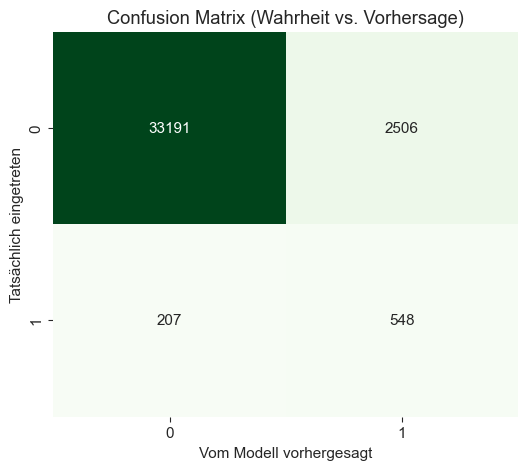

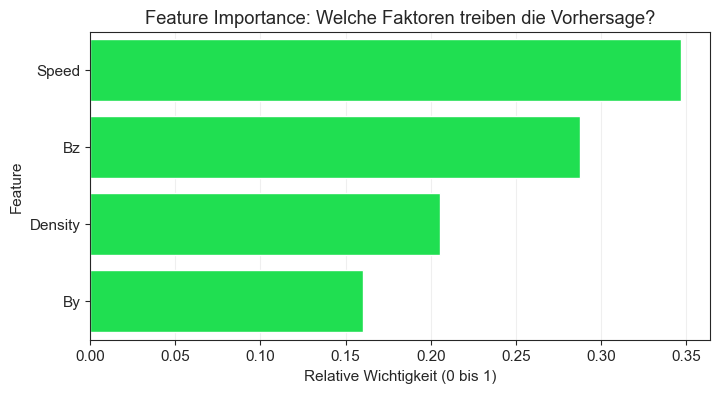


--- HYPOTHESEN ÜBERPRÜFUNG ---
✅ H1 BESTÄTIGT: Physikalische Parameter (Bz/Speed) korrelieren signifikant mit dem Kp-Index.
   (Wichtigste Faktoren: ['Speed' 'Bz'])
✅ H2 BESTÄTIGT: Der Random Forest erreicht eine Genauigkeit von 92.6% (Ziel war > 85%).


In [ ]:
print("--- MODEL PERFORMANCE ---")
# A) Classification Report
print(classification_report(y_test, y_pred, target_names=['Kein Sturm', 'Sturm']))

# B) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix (Wahrheit vs. Vorhersage)')
plt.xlabel('Vom Modell vorhergesagt')
plt.ylabel('Tatsächlich eingetreten')
plt.show()

# C) Feature Importance
importances = pd.DataFrame({
    'Feature': features,
    'Wichtigkeit': model.feature_importances_
}).sort_values(by='Wichtigkeit', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Wichtigkeit', y='Feature', data=importances, color='#00ff41')
plt.title('Feature Importance: Welche Faktoren treiben die Vorhersage?')
plt.xlabel('Relative Wichtigkeit (0 bis 1)')
plt.show()

# D) HYPOTHESEN-CHECK
print("\n--- HYPOTHESEN ÜBERPRÜFUNG ---")

# Check zu H1: Sind Bz oder Speed wichtig?
top_features = importances.head(2)['Feature'].values
if 'Bz' in top_features or 'Speed' in top_features:
    print("✅ H1 BESTÄTIGT: Physikalische Parameter (Bz/Speed) korrelieren signifikant mit dem Kp-Index.")
    print(f"   (Wichtigste Faktoren: {top_features})")
else:
    print("❌ H1 nicht eindeutig bestätigt.")

# Check zu H2: Ist Accuracy > 85%?

if acc >= 0.85:
    print(f"✅ H2 BESTÄTIGT: Der Random Forest erreicht eine Genauigkeit von {acc:.1%} (Ziel war > 85%).")
else:
    print(f"⚠️ H2 knapp verfehlt: Genauigkeit liegt bei {acc:.1%}.")